# Dataset generation and exploratory data analysis

In [2]:
# add parent dir to path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from pathlib import Path
from params import PATH_DATA, PATH_OUT

import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

from fastprogress.fastprogress import progress_bar

import matplotlib.image as mpimg

from tools import csv2ndarray, get_label
import hashlib

In [3]:
path_data_npy = PATH_OUT / "data_npy"
path_data_npy.mkdir(exist_ok=True, parents=True)

## 1. Labels distribution
Labels are enoded in filename. It is the word after the last underscore, before the dot.

In [4]:
fnames = list(PATH_DATA.rglob("*.csv"))

def get_label(fname):
    return fname.name.split('.')[0].split('_')[-1]

labels = [get_label(fname) for fname in fnames]
c = Counter(labels)
c

Counter({'OK': 4676, 'empty': 3815, 'WARNING': 1119})

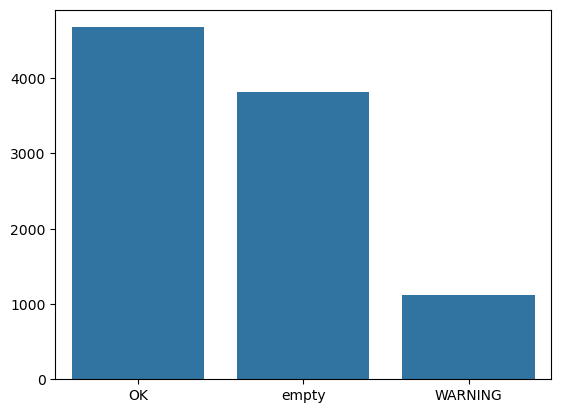

In [5]:
# plot the distribution of the labels
sns.barplot(x=list(c.keys()), y=list(c.values()));

We see that we have three classes: `OK`, `empty` and `WARNING`, classes are not balanced. `empty` label means that we actially do not have a label. That's mean that in case of several conflicting labels, one of which is `empty` we may assign the class of the plate to the different label:</br>
* (`empty`, `OK`) -> `OK`
* (`empty`, `WARNING`) -> `WARNING`

## 2. Extract arrays from the `.csv` files and save them to `.npy` format

In [6]:
for fname in progress_bar(list(PATH_DATA.rglob("*.csv"))):
    name = fname.name
    parent = fname.parent.name
    # crate a parent dir if it doesn't exist
    (path_data_npy / parent).mkdir(exist_ok=True)
    df = pd.read_csv(fname, index_col=0)
    values = df.values
    # fill NA values with 0
    values = np.nan_to_num(values)
    np.save(path_data_npy / parent / f"{name[:-4]}.npy", values)

## 3. Explore duplicates per experiments group
Each experiments group (`COMBO-11`, ..., `CTF-P019`) may contain the same plates, but with different labels, encoded in their names. Let's find out those duplicates.

In [45]:
# check if `data_hashes.csv` exists and load if so
if (PATH_OUT / "data_hashes.csv").exists():
    df_hashes = pd.read_csv(PATH_OUT / "data_hashes.csv", index_col=0)
else:
    df_hashes = pd.DataFrame(columns=["experiment_group", "fname", "name", "label", "hash"])
    fnames = list(path_data_npy.rglob("*.npy"))
    for idx, fname in progress_bar(enumerate(fnames), total=len(fnames)):
        name = fname.name
        parent = fname.parent.name
        values = np.load(fname)
        hash = hashlib.md5(str(values).encode()).hexdigest()
        df_hashes.loc[idx] = [parent, fname, name, get_label(fname), hash]
    
    df_hashes.to_csv(PATH_OUT / "data_hashes.csv")

In [47]:
df_hashes.head()

,experiment_group,fname,name,label,hash
0,CTF-P007,../out/data_npy/CTF-P007/plate_17305eb6f8d7_OK...,plate_17305eb6f8d7_OK.npy,OK,2aad337f0fac9e7a3b2b640d0f6c7a04
1,CTF-P007,../out/data_npy/CTF-P007/plate_1730d1b301_OK.npy,plate_1730d1b301_OK.npy,OK,b1e922e435b537a29f56a3bf2e8c8270
2,CTF-P007,../out/data_npy/CTF-P007/plate_173028eaef6f_OK...,plate_173028eaef6f_OK.npy,OK,65c9988aa9fa604541ef25873fda2b32
3,CTF-P007,../out/data_npy/CTF-P007/plate_17305a2c7b5a_WA...,plate_17305a2c7b5a_WARNING.npy,WARNING,d5b9318dade81b4802799f35a67bfce0
4,CTF-P007,../out/data_npy/CTF-P007/plate_1730739b905b_OK...,plate_1730739b905b_OK.npy,OK,14cb73ead9df0e122b36f830bb7e6a5b


In [48]:
df_hashes.fname.unique().shape

(9610,)

We have `9610` plates, but do we have any duplicates?

In [49]:
df_hashes.hash.unique().shape

(3372,)

So, we have only `3372` unique plates.<br>What is the distribution of labels among the files with identical hashes?

In [50]:
df_hashes.hash.value_counts()

hash
3837731e6d328ae032cd380c08cc7cce    70
40b908203ff65f28255436809565d903    26
2983a0ecc9e36a773a05e12d4a83f057    26
344d461bcc2cf6a8b425ba1b574a4bc2    21
0ff9e20ecd5a3b4d41198604ce9e58ad    21
                                    ..
ed7500c0715cf92e21bfeb687469b58f     1
a9341e45223abcd81a9d82cf3ec235ab     1
e61add6a9c517aaa3c55037a29421bb3     1
d8fa1b29f0fae63ca95037d5f38defea     1
634a22af5e1b55a990b6b94e3da84248     1
Name: count, Length: 3372, dtype: int64

In [51]:
# get index of pandas series where value is True
hashes_duplicates = df_hashes.hash.value_counts().index[df_hashes.hash.value_counts() > 1].to_list()
print(f"len(hashes_duplicates): {len(hashes_duplicates)}")
hashes_duplicates[:5]

len(hashes_duplicates): 2606


['3837731e6d328ae032cd380c08cc7cce',
 '40b908203ff65f28255436809565d903',
 '2983a0ecc9e36a773a05e12d4a83f057',
 '344d461bcc2cf6a8b425ba1b574a4bc2',
 '0ff9e20ecd5a3b4d41198604ce9e58ad']

In [52]:
hashes_no_duplicates = df_hashes.hash.value_counts().index[df_hashes.hash.value_counts() == 1].to_list()
print(f"len(hashes_no_duplicates): {len(hashes_no_duplicates)}")
hashes_no_duplicates[:5]

len(hashes_no_duplicates): 766


['6a4cc267a0791293619075463555ba15',
 '0feb1ae8ed7e155dc750794c63b8782a',
 'dc14b7014a3a2b1a77e1ab8ed85fd331',
 'c7363717d0ef3ff1179d51ee6a981233',
 '0b1cb501c19bf587a14029367ced5b2c']

Labels distribution per hash:

In [8]:
# check if `data_hashes_duplicates.csv` exists and load if so
if (PATH_OUT / "data_hashes_duplicates.csv").exists():
    df_hashes_dup = pd.read_csv(PATH_OUT / "data_hashes_duplicates.csv", index_col=0)
else:
    df_hashes_dup = pd.DataFrame(columns=["hash", "OK", "empty", "WARNING"])

    for idx, hash in progress_bar(enumerate(hashes_duplicates), total=len(hashes_duplicates)):
        # select all rows with the same hash
        df = df_hashes[df_hashes.hash == hash]
        d = df.label.value_counts().to_dict()
        keys = ["OK", "empty", "WARNING"]
        for key in keys:
            if key not in d:
                d[key] = 0
        df_hashes_dup.loc[idx] = [hash] + list(d.values())

    df_hashes_dup.to_csv(PATH_OUT / "data_hashes_duplicates.csv")

In [9]:
df_hashes_dup

,hash,OK,empty,WARNING
0,3837731e6d328ae032cd380c08cc7cce,70,0,0
1,40b908203ff65f28255436809565d903,20,6,0
2,2983a0ecc9e36a773a05e12d4a83f057,20,6,0
3,344d461bcc2cf6a8b425ba1b574a4bc2,14,7,0
4,0ff9e20ecd5a3b4d41198604ce9e58ad,14,7,0
...,...,...,...,...
2601,36440c720951e6b0796fb97c4655f1c8,2,0,0
2602,e476450941452d92a8b9cb9a688dcb49,2,0,0
2603,6efb3d9495532fb69a8fea3e6442febb,2,0,0
2604,272f3a2ea8200b1d97b6a9331a08ac9b,1,1,0


In [10]:
df_hashes_dup.dtypes

hash       object
OK          int64
empty       int64
WARNING     int64
dtype: object

In [11]:
# get number of columns with int64 dtype
df_hashes_dup.select_dtypes(include=["int64"]).shape[1]

3

In [16]:
df_hashes_dup.iloc[0]

hash       3837731e6d328ae032cd380c08cc7cce
OK                                       70
empty                                     0
WARNING                                   0
Name: 0, dtype: object

How many of hashes has only one unique label?

In [34]:
def only_one_label(row):
    n_int_cols = sum(pd.api.types.is_integer_dtype(type(val)) for val in row)
    if not 0 in row.value_counts():
        return False
    if row.value_counts()[0] == (n_int_cols - 1):
        return True
    return False

In [35]:
only_one_label_count = 0
# iterate over all rows in df_hashes_dup
for idx, row in progress_bar(df_hashes_dup.iterrows(), total=len(df_hashes_dup)):
    n_int_cols = df_hashes_dup.select_dtypes(include=["int64"]).shape[1]
    if only_one_label(row):
        only_one_label_count += 1
print(f"only_one_label_count: {only_one_label_count}")

only_one_label_count: 711


In [36]:
df_hashes_dup.shape

(2606, 4)

So, we have `711` hashes without conflicting labels. What is the distribution of labels in the rest of `2606` - `711` = `1895` cases?

In [37]:
def more_than_one_label(row):
    return not only_one_label(row)

# select all rows which have more than one label
df_hashes_dup_more_than_one_label = df_hashes_dup[df_hashes_dup.apply(more_than_one_label, axis=1)]
df_hashes_dup_more_than_one_label.shape

(1895, 4)

In [38]:
df_hashes_dup_more_than_one_label

,hash,OK,empty,WARNING
1,40b908203ff65f28255436809565d903,20,6,0
2,2983a0ecc9e36a773a05e12d4a83f057,20,6,0
3,344d461bcc2cf6a8b425ba1b574a4bc2,14,7,0
4,0ff9e20ecd5a3b4d41198604ce9e58ad,14,7,0
5,af228898c7c84ed9ac2eabe9d167a128,14,7,0
...,...,...,...,...
2576,29fc4d7d134b7871d5c08dc4c1842a80,1,1,0
2591,5046af52a678cbc82f68c0e641900117,1,1,0
2594,95dd0bcea896ab68db4158bfb1323f96,1,1,0
2595,13a31b9bdaa1530ede662729290f6168,1,1,0


Drop `empty` label count. We may ignore it unless there is at least one label of other type. If all labels we have just `empty`, we don't know the type of label.

In [39]:
# drop column 'empty'
df_hashes_dup_more_than_one_label = df_hashes_dup_more_than_one_label.drop("empty", axis=1)

In [40]:
df_hashes_dup_more_than_one_label.head()

,hash,OK,WARNING
1,40b908203ff65f28255436809565d903,20,0
2,2983a0ecc9e36a773a05e12d4a83f057,20,0
3,344d461bcc2cf6a8b425ba1b574a4bc2,14,0
4,0ff9e20ecd5a3b4d41198604ce9e58ad,14,0
5,af228898c7c84ed9ac2eabe9d167a128,14,0


In [60]:
df_hashes_dup_more_than_one_label.shape

(1895, 3)

If there are any rows with zeroes both in `OK` and `WARNING` columns - remove those:

In [41]:
df_hashes_dup_more_than_one_label[(df_hashes_dup_more_than_one_label['OK'] == 0) & (df_hashes_dup_more_than_one_label['WARNING'] == 0)].shape

(0, 3)

Ok, no rows should be removed, because we don't know labels at all. But do we have rows where simultaneously non-zero values in columns `OK` and `WARNING`?

In [42]:
df_hashes_dup_more_than_one_label[(df_hashes_dup_more_than_one_label['OK'] != 0) & (df_hashes_dup_more_than_one_label['WARNING'] != 0)].shape

(97, 3)

Extract unique plates with well-defined labels. It means unique plates or plates that have duplicates but all of those duplicates have the same label:

In [67]:
# hashes of all plates that have duplicates, but only one label
hashes_dup_unique_label_lst = df_hashes_dup_more_than_one_label[df_hashes_dup_more_than_one_label.apply(only_one_label, axis=1)].hash.to_list()

In [68]:
len(hashes_dup_unique_label_lst)

1798

In [69]:
hashes_reliable_labels = hashes_no_duplicates + hashes_dup_unique_label_lst
print(f"len(hashes_reliable_labels): {len(hashes_reliable_labels)}")

len(hashes_reliable_labels): 2564


Get the dataframe with plates which have only reliable labels:

In [80]:
len(set(hashes_reliable_labels))

2564

In [81]:
df_hashes_reliable_labels = df_hashes[df_hashes.hash.isin(hashes_reliable_labels)]
df_hashes_reliable_labels

,experiment_group,fname,name,label,hash
2,CTF-P007,../out/data_npy/CTF-P007/plate_173028eaef6f_OK...,plate_173028eaef6f_OK.npy,OK,65c9988aa9fa604541ef25873fda2b32
3,CTF-P007,../out/data_npy/CTF-P007/plate_17305a2c7b5a_WA...,plate_17305a2c7b5a_WARNING.npy,WARNING,d5b9318dade81b4802799f35a67bfce0
4,CTF-P007,../out/data_npy/CTF-P007/plate_1730739b905b_OK...,plate_1730739b905b_OK.npy,OK,14cb73ead9df0e122b36f830bb7e6a5b
5,CTF-P007,../out/data_npy/CTF-P007/plate_17301dc9b176_em...,plate_17301dc9b176_empty.npy,empty,0776f9e5312333ce055ce519b12edd57
6,CTF-P007,../out/data_npy/CTF-P007/plate_17303b157f6d_em...,plate_17303b157f6d_empty.npy,empty,919b8debbc848bc44a4ce8b557ed5e59
...,...,...,...,...,...
9605,CTF-P010,../out/data_npy/CTF-P010/plate_1730752ca902_OK...,plate_1730752ca902_OK.npy,OK,961dfe4c249eacd4ffd0b2841e9d0b00
9606,CTF-P010,../out/data_npy/CTF-P010/plate_17306c6618b0_em...,plate_17306c6618b0_empty.npy,empty,c9b571714aba2fa4758ca6078122be6a
9607,CTF-P010,../out/data_npy/CTF-P010/plate_173020416f9_emp...,plate_173020416f9_empty.npy,empty,ceed04d57b849b59007cdefdaeec8b76
9608,CTF-P010,../out/data_npy/CTF-P010/plate_17305cdea61f_em...,plate_17305cdea61f_empty.npy,empty,062d4049317a8b32bad700628a09effa


In [82]:
df_hashes_reliable_labels.label.value_counts()

label
empty      3235
OK         3220
WARNING     951
Name: count, dtype: int64

In [83]:
df_hashes_reliable_labels.hash.unique().shape

(2564,)

In [84]:
# drop rows that have the label value equal to `empty`
df_hashes_reliable_labels = df_hashes_reliable_labels[df_hashes_reliable_labels.label != "empty"]
df_hashes_reliable_labels.shape

(4171, 5)

In [85]:
df_hashes_reliable_labels.label.value_counts()

label
OK         3220
WARNING     951
Name: count, dtype: int64

In [87]:
# remove duplicate rows
df_hashes_reliable_labels = df_hashes_reliable_labels.drop_duplicates(subset=["hash"], keep="first")
df_hashes_reliable_labels.shape

(2424, 5)

In [88]:
df_hashes_reliable_labels.label.value_counts()

label
OK         1704
WARNING     720
Name: count, dtype: int64

In [89]:
# save to the out folder
df_hashes_reliable_labels.to_csv(PATH_OUT / "data_hashes_reliable_labels.csv")

Actual distribution of the labels of plates, ignoring plates with conflicting labels:

In [90]:
df_hashes_reliable_labels

,experiment_group,fname,name,label,hash
2,CTF-P007,../out/data_npy/CTF-P007/plate_173028eaef6f_OK...,plate_173028eaef6f_OK.npy,OK,65c9988aa9fa604541ef25873fda2b32
3,CTF-P007,../out/data_npy/CTF-P007/plate_17305a2c7b5a_WA...,plate_17305a2c7b5a_WARNING.npy,WARNING,d5b9318dade81b4802799f35a67bfce0
4,CTF-P007,../out/data_npy/CTF-P007/plate_1730739b905b_OK...,plate_1730739b905b_OK.npy,OK,14cb73ead9df0e122b36f830bb7e6a5b
10,CTF-P007,../out/data_npy/CTF-P007/plate_17301d19e504_WA...,plate_17301d19e504_WARNING.npy,WARNING,6dabf3e595a6287f5dd9a82817f02cd5
13,CTF-P007,../out/data_npy/CTF-P007/plate_17302c91550a_OK...,plate_17302c91550a_OK.npy,OK,f32b591d227072bdb1bdad28f7c83b90
...,...,...,...,...,...
9591,CTF-P010,../out/data_npy/CTF-P010/plate_17301ac9221_OK.npy,plate_17301ac9221_OK.npy,OK,4ee2e8921535272a76df532ff61ac825
9599,CTF-P010,../out/data_npy/CTF-P010/plate_17307182f682_OK...,plate_17307182f682_OK.npy,OK,5b31e42f0d5960514edba516942b5340
9600,CTF-P010,../out/data_npy/CTF-P010/plate_17307cc4506e_WA...,plate_17307cc4506e_WARNING.npy,WARNING,5a1209bd1b18b0fae51d43b74ae9af87
9605,CTF-P010,../out/data_npy/CTF-P010/plate_1730752ca902_OK...,plate_1730752ca902_OK.npy,OK,961dfe4c249eacd4ffd0b2841e9d0b00


In [91]:
c = Counter(df_hashes_reliable_labels.label)
c

Counter({'OK': 1704, 'WARNING': 720})

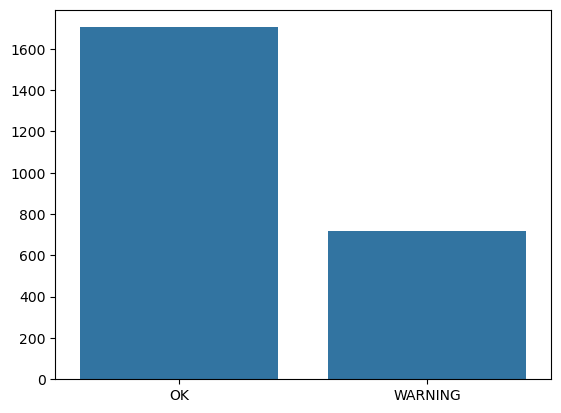

In [92]:
sns.barplot(x=list(c.keys()), y=list(c.values()));

In [93]:
df_hashes_reliable_labels = pd.read_csv(PATH_OUT / "data_hashes_reliable_labels.csv", index_col=0)

## 4. Explore shapes distribution of images
Below we consider only images that have the reliable labels as defined above.

In [94]:
df_hashes_reliable_labels.columns

Index(['experiment_group', 'fname', 'name', 'label', 'hash'], dtype='object')

In [95]:
df_hashes_reliable_labels.fname

2       ../out/data_npy/CTF-P007/plate_173028eaef6f_OK...
3       ../out/data_npy/CTF-P007/plate_17305a2c7b5a_WA...
4       ../out/data_npy/CTF-P007/plate_1730739b905b_OK...
10      ../out/data_npy/CTF-P007/plate_17301d19e504_WA...
13      ../out/data_npy/CTF-P007/plate_17302c91550a_OK...
                              ...                        
9591    ../out/data_npy/CTF-P010/plate_17301ac9221_OK.npy
9599    ../out/data_npy/CTF-P010/plate_17307182f682_OK...
9600    ../out/data_npy/CTF-P010/plate_17307cc4506e_WA...
9605    ../out/data_npy/CTF-P010/plate_1730752ca902_OK...
9609    ../out/data_npy/CTF-P010/plate_173027076f4b_OK...
Name: fname, Length: 2424, dtype: object

In [96]:
shapes = []
for fname in progress_bar(df_hashes_reliable_labels.fname):
    name = fname.split('.')[0]
    values = np.load(fname)
    shapes.append(values.shape)

In [97]:
c = Counter(shapes)
c

Counter({(16, 24): 1583,
         (8, 12): 272,
         (14, 22): 213,
         (14, 12): 79,
         (13, 20): 64,
         (14, 21): 56,
         (6, 10): 48,
         (7, 22): 41,
         (14, 11): 38,
         (16, 13): 20,
         (16, 12): 4,
         (12, 22): 3,
         (12, 20): 2,
         (14, 24): 1})

The fact that some shapes can be obtained by multiplication of other shapes may be a hint to splitting plates into the subplates  of unified shape, e.g. `14 x 22` and `14 x 11`can be considered as a combination of subplates of shapes `7 x 11`.

## 5. Select entries with the most common shapes
Let's work with the shapes `14 x 22` and `16 x 24`. Those provides 426 + 392 = 818 that is more than 50% of all images with reliable labels.

In [34]:
df_hashes_reliable_labels.iloc[0]

experiment_group                                             CTF-P007
fname               ../out/data_npy/CTF-P007/plate_17305eb6f8d7_OK...
name                                        plate_17305eb6f8d7_OK.npy
label                                                              OK
hash                                 2aad337f0fac9e7a3b2b640d0f6c7a04
Name: 0, dtype: object

In [37]:
required_shapes = [(14, 22), (16, 24)]
def is_proper_shape(series, required_shapes=required_shapes):
    fname = series.fname
    values = np.load(fname)
    return values.shape in required_shapes

In [38]:
df_hashes_reliable_labels_ = df_hashes_reliable_labels[df_hashes_reliable_labels.apply(is_proper_shape, axis=1)]

In [39]:
df_hashes_reliable_labels_.shape

(818, 5)

In [41]:
df_hashes_reliable_labels_.label.value_counts()

label
OK         574
empty      177
WARNING     67
Name: count, dtype: int64

In [42]:
# save to the out folder
df_hashes_reliable_labels_.to_csv(PATH_OUT / "data_hashes_reliable_labels_top_shapes.csv")

Below is experimental code not used in the pipeline.

Upscale images to `224 x 224`:

In [ ]:
# read .png file to numpy array
from PIL import Image

im = Image.open(p)
im = np.array(im)
im.shape

The fourth channel contains only `255` values.

In [ ]:
np.unique(im[:, :,3])

In [ ]:
import cv2

img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

In [ ]:
plt.imshow(res);

In [ ]:
img.shape